In [1]:
from alignment_parser import *
from alignment_manipulations import *
from csc_plotter import *
from dt_plotter import *
from gem_plotter import *

Welcome to JupyROOT 6.28/00


# Preparation
.db file stores global coordinates of detectors and their rawId. rawId is a 32-bit unsigned integer.  The four most significant bits (31:28) identify the large-scale detector while the next three bits (27:25) identify a part of the detector. There are several exeptions. To make it easier we use report.py file from TBMA to match CSC detectors\layers with it's id. You can use any report.py file, it uses it only to match CSC with ID.

In [18]:
df_report = parse_csc_reports('data/iter3_report.py', 'report')

Now you need to save desired tag from db file to txt file. To do that you need to have .db file with CSC geometry.
To save it to .txt do following:
1. Go to your $CMSSW/src
2. cmsenv
3. conddb --db yourgeom.db status
4. find tag with CSC geometry (usually CSCAlignmentRcd) copy the payload of it
5. conddb --db yourgeom.db dump --format xml --type payload yourpayload > yourgeom.txt
Then parse this file:

In [19]:
def parse_db(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    data = []
    for item in root.findall('.//item'):
        raw_id = int(item.find('m-rawId').text)
        dx = np.float64(item.find('m-translation/dx').text)
        dy = np.float64(item.find('m-translation/dy').text)
        dz = np.float64(item.find('m-translation/dz').text)
        phi = np.float64(item.find('m-eulerAngles/phi_').text)
        theta = np.float64(item.find('m-eulerAngles/theta_').text)
        psi = np.float64(item.find('m-eulerAngles/psi_').text)

        data.append({
            'rawID': raw_id,
            'dx': dx,
            'dy': dy,
            'dz': dz,
            'phi': phi,
            'theta': theta,
            'psi': psi
        })

    df = pd.DataFrame(data)
    return df

# Example usage
file_path = 'data/global.txt'
db_geom = parse_db(file_path)

In [20]:
df_report

,chamberId,endcap,station,ring,chamber,name,posNum,negNum,fittype,x,...,phix,phiy,phiz,loglikelihood,numsegments,sumofweights,redchi2,stats,covmatrix,type
0,604017672,1,1,1,1,report,2933,0,6DOFrphi,-0.003293,...,0.0,0.0,0.000112,914.465,2933.0,2933.0,0.0,None,"[1.10825e-05, 1.70486e-06, -5.53622e-08, 1.643...",CSCChamber
1,604017688,1,1,1,3,report,2806,0,6DOFrphi,0.001230,...,0.0,0.0,-0.000036,1011.510,2806.0,2806.0,0.0,None,"[1.06354e-05, 9.29182e-06, -6.04827e-08, 1.786...",CSCChamber
2,604017704,1,1,1,5,report,2898,0,6DOFrphi,-0.000979,...,0.0,0.0,-0.000021,848.084,2898.0,2898.0,0.0,None,"[1.15662e-05, 5.80078e-06, -5.09226e-08, 1.897...",CSCChamber
3,604017720,1,1,1,7,report,2745,0,6DOFrphi,-0.000529,...,0.0,0.0,0.000011,932.293,2745.0,2745.0,0.0,None,"[1.11952e-05, -5.67721e-06, -5.50665e-08, 1.84...",CSCChamber
4,604017736,1,1,1,9,report,2674,0,6DOFrphi,-0.000767,...,0.0,0.0,-0.000010,885.195,2674.0,2674.0,0.0,None,"[1.19714e-05, -9.89412e-06, -7.50572e-08, 2.01...",CSCChamber
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,604062944,2,4,2,28,report,2063,0,6DOFrphi,-0.010295,...,0.0,0.0,0.000032,-2826.360,2063.0,2063.0,0.0,None,"[0.000551841, 0.000385273, -2.77503e-06, 1.200...",CSCChamber
608,604062960,2,4,2,30,report,1641,0,6DOFrphi,0.008614,...,0.0,0.0,-0.000273,-2174.070,1641.0,1641.0,0.0,None,"[0.000875382, -0.00306558, -6.03993e-06, -1.08...",CSCChamber
609,604062976,2,4,2,32,report,1944,0,6DOFrphi,0.014699,...,0.0,0.0,-0.000277,-2616.450,1944.0,1944.0,0.0,None,"[0.000696638, 0.000931249, -4.76245e-06, 8.047...",CSCChamber
610,604062992,2,4,2,34,report,2284,0,6DOFrphi,0.001334,...,0.0,0.0,-0.000154,-3176.430,2284.0,2284.0,0.0,None,"[0.000480189, 0.000177403, -2.03319e-06, 1.392...",CSCChamber


In [21]:
import pandas as pd

def create_layered_dataframe(df_report, db_geom):
    # Create an empty list to store the results
    results = []
    
    # Iterate over each row in df_report
    for _, row in df_report.iterrows():
        chamber_id = row['chamberId']
        endcap = row['endcap']
        station = row['station']
        ring = row['ring']
        chamber = row['chamber']
        
        # Find the corresponding entry in db_geom for the chamber
        chamber_geom = db_geom[db_geom['rawID'] == chamber_id]
        
        if not chamber_geom.empty:
            chamber_geom_row = chamber_geom.iloc[0]
            # Add the chamber itself with layer 0
            results.append({
                'endcap': endcap,
                'station': station,
                'ring': ring,
                'chamber': chamber,
                'layer': 0,
                'dx': chamber_geom_row['dx'],
                'dy': chamber_geom_row['dy'],
                'dz': chamber_geom_row['dz'],
                'phi': chamber_geom_row['phi'],
                'theta': chamber_geom_row['theta'],
                'psi': chamber_geom_row['psi']
            })
        
            # Generate entries for layers 1 to 6
            for layer in range(1, 7):
                # Calculate the rawID for this specific layer
                layer_rawID = chamber_id + layer
                
                # Find corresponding geometry in db_geom for the specific layer
                layer_geom = db_geom[db_geom['rawID'] == layer_rawID]
                
                if not layer_geom.empty:
                    geom_row = layer_geom.iloc[0]
                    # Append the new row to the results list
                    results.append({
                        'endcap': endcap,
                        'station': station,
                        'ring': ring,
                        'chamber': chamber,
                        'layer': layer,
                        'dx': geom_row['dx'],
                        'dy': geom_row['dy'],
                        'dz': geom_row['dz'],
                        'phi': geom_row['phi'],
                        'theta': geom_row['theta'],
                        'psi': geom_row['psi']
                    })
    
    # Convert the results list to a DataFrame
    output_df = pd.DataFrame(results)
    
    return output_df

# Example usage:
# df_report and db_geom are assumed to be predefined DataFrames
result_df = create_layered_dataframe(df_report, db_geom)


In [22]:
result_df

,endcap,station,ring,chamber,layer,dx,dy,dz,phi,theta,psi
0,1,1,1,1,0,181.966354,0.050277,616.950012,0.785213,3.141593,-0.785213
1,1,1,1,1,1,181.966350,0.039669,611.280029,0.785213,3.141593,-0.785213
2,1,1,1,1,2,181.966352,0.044145,613.480042,0.785213,3.141593,-0.785213
3,1,1,1,1,3,181.966354,0.048517,615.680054,0.785213,3.141593,-0.785213
4,1,1,1,1,4,181.966357,0.057234,617.880005,0.785213,3.141593,-0.785213
...,...,...,...,...,...,...,...,...,...,...,...
4279,2,4,2,36,2,516.763550,-90.772232,-1041.437744,0.697922,3.141593,-0.697922
4280,2,4,2,36,3,516.763550,-90.772232,-1038.897705,0.697922,3.141593,-0.697922
4281,2,4,2,36,4,516.763550,-90.772232,-1036.357666,0.697922,3.141593,-0.697922
4282,2,4,2,36,5,516.763550,-90.772232,-1033.817627,0.697922,3.141593,-0.697922


Lets plot CSC in global

In [27]:
import plotly.graph_objects as go

def plot_3d_chamber_layers(df, endcap, station, ring, chamber):
    # Filter the dataframe based on the input parameters
    chamber_df = df[(df['endcap'] == endcap) & 
                    (df['station'] == station) & 
                    (df['ring'] == ring) & 
                    (df['chamber'] == chamber)]
    
    # Initialize a plotly figure
    fig = go.Figure()

    # Plot the chamber itself (layer = 0)
    chamber_data = chamber_df[chamber_df['layer'] == 0]
    fig.add_trace(go.Scatter3d(
        x=chamber_data['dx'],
        y=chamber_data['dy'],
        z=chamber_data['dz'],
        mode='markers',
        marker=dict(size=5, color='blue', opacity=0.8),
        name='Chamber'
    ))

    # Plot the layers (layer = 1 to 6)
    layer_data = chamber_df[chamber_df['layer'] != 0]
    fig.add_trace(go.Scatter3d(
        x=layer_data['dx'],
        y=layer_data['dy'],
        z=layer_data['dz'],
        mode='markers',
        marker=dict(size=5, color='red', opacity=0.8),
        name='Layers 1-6'
    ))

    # Set axis titles and update layout
    fig.update_layout(scene=dict(
        xaxis_title='dx',
        yaxis_title='dy',
        zaxis_title='dz'
    ),
    width=700, height=700,
    title=f'3D Plot for Endcap {endcap}, Station {station}, Ring {ring}, Chamber {chamber}')

    # Show the plot
    fig.show()

# Example usage:
plot_3d_chamber_layers(result_df, endcap=1, station=1, ring=1, chamber=2)


Attempt to calculate phi_y
phi_y calculated in local coordinates. Global coordinates are used only to determine distance between layers because local z = global z

In [28]:
CSCLayerAlLa = parse_xml_alignment(file_path="data/CSCLaAl.xml",
                                   detector_type="CSCLayer",
                                   name = "CSCLayer Alignment Layer")

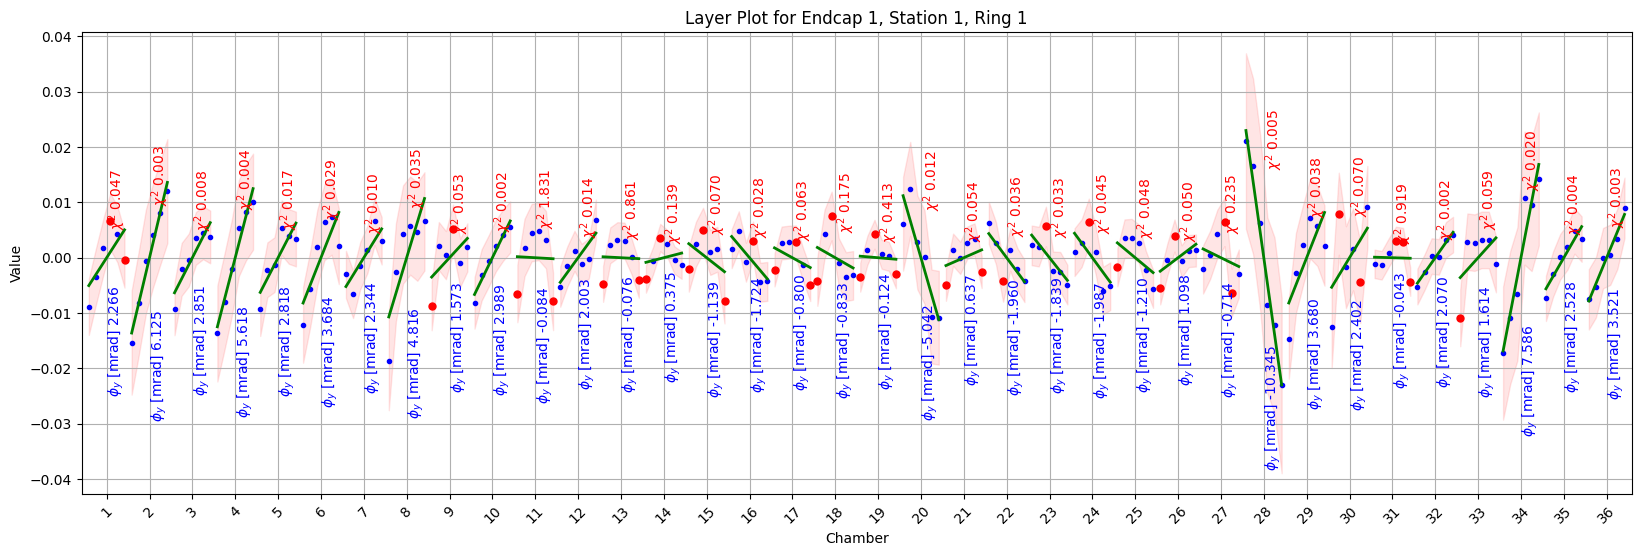

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_layers_in_ring(df, result_df, endcap, station, ring, title="Layer Plot", x_label="Chamber", y_label="Value", outlier_threshold=1):
    # Filter the DataFrame based on the input endcap, station, and ring
    filtered_df = df[(df['endcap'] == endcap) & 
                     (df['station'] == station) & 
                     (df['ring'] == ring)]
    
    # Sort by chamber and layer to ensure proper ordering
    filtered_df = filtered_df.sort_values(by=['chamber', 'layer'])
    
    # Filter result_df for the same endcap, station, and ring
    filtered_result_df = result_df[(result_df['endcap'] == endcap) & 
                                   (result_df['station'] == station) & 
                                   (result_df['ring'] == ring)]
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Extract the relevant data
    chambers = filtered_df['chamber'].unique()
    num_chambers = len(chambers)
    
    for i, chamber in enumerate(chambers):
        chamber_data = filtered_df[filtered_df['chamber'] == chamber]
        result_chamber_data = filtered_result_df[filtered_result_df['chamber'] == chamber]
        
        data_list = chamber_data['x']  # Replace 'x' with the appropriate column name if needed
        
        # Center the data around 0 by subtracting the mean
        data_list_centered = data_list - data_list.mean()

        # Calculate the x positions for this chamber's layers
        x = np.arange(i * 6, i * 6 + 6)
        
        # Plot the data points
        ax.plot(x, data_list_centered, marker='o', linestyle='-', color='b', linewidth=0, markersize=3)
        
        # Calculate STD for each chamber (6 layers per chamber)
        std = np.std(data_list_centered)
        
        # Plot STD range for this chamber
        upper_bound = data_list_centered + std
        lower_bound = data_list_centered - std
        ax.fill_between(x, upper_bound, lower_bound, alpha=0.1, color='r')

        # Perform linear regression on this chamber's layers
        x_window = np.array(range(len(data_list_centered)))
        y_window = data_list_centered

        # Linear regression
        m, b = np.polyfit(x_window, y_window, 1)
        y_fit = m * x_window + b

        # Plot the linear fit line
        ax.plot(x, y_fit, color='g', linewidth=2)

        # Calculate chi-square
        chi_square = np.sum(((y_window - y_fit) ** 2) / abs(y_fit))

        # Annotate chi-square value on the plot
        ax.annotate("$\chi^2$ "+ f'{chi_square:.3f}', xy=(x.mean(), y_window.mean()), 
                    xytext=(x.mean(), y_window.mean() + std), color='red', rotation=90, 
                    verticalalignment='bottom')

        # Calculate dz difference for the slope calculation
        dz_diff = result_chamber_data['dz'].diff().iloc[1:]  # Ignore first NaN difference
        avg_dz_diff = dz_diff.mean() if not dz_diff.empty else 2.2  # Fallback to 2.2 if dz_diff is empty

        # Annotate slope coefficient (slope converted to mrad)
        ax.annotate("$\phi_y$ [mrad] "+f'{m*1000/avg_dz_diff:.3f}', xy=(x.mean(), y_window.mean()), 
                    xytext=(x.mean(), y_window.mean() - std), color='blue', rotation=90, 
                    verticalalignment='top')

        # Detect and highlight outliers
        residuals = y_window - y_fit
        outliers = np.abs(residuals) > outlier_threshold * std

        # Highlight outliers in red
        ax.plot(x[outliers], y_window[outliers], 'ro', markersize=5)

    # Set x-axis ticks and labels for chambers
    chamber_ticks = np.arange(0, num_chambers * 6, 6) + 2.5  # Offset to center ticks under each set of layers
    ax.set_xticks(chamber_ticks)
    ax.set_xticklabels(chambers, rotation=45)

    # Set x and y limits
    ax.set_xlim(-1, num_chambers * 6)

    # Set title, x-label, and y-label
    ax.set_title(f"{title} for Endcap {endcap}, Station {station}, Ring {ring}")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Enable grid
    ax.grid(True)

    # Show the plot
    plt.show()

# Example usage:
plot_layers_in_ring(CSCLayerAlLa,result_df, endcap=1, station=1, ring=1, title="Layer Plot", x_label="Chamber", y_label="Value")


In [ ]:
from alignment_parser import *
from alignment_manipulations import *
from csc_plotter import *
from dt_plotter import *
from gem_plotter import *

Welcome to JupyROOT 6.28/00
